# Import and global variable

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
import datetime
now  = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
print(datetime.datetime.now())
print(now)

2020-06-01 08:27:48.124472
20200601_082748


In [3]:
xl_writer = pd.ExcelWriter(f"covid19_world_data_{now}.xlsx")

# Data

data from https://github.com/CSSEGISandData/COVID-19

or

https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

# Cases

In [4]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

In [5]:
df = pd.read_csv(url)

In [6]:
df.to_excel(xl_writer, "raw")

In [7]:
df.drop(columns=['Lat', 'Long'], inplace=True)

In [8]:
df.head()

Province/State Country/Region  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
0            NaN    Afghanistan        0        0        0        0        0   
1            NaN        Albania        0        0        0        0        0   
2            NaN        Algeria        0        0        0        0        0   
3            NaN        Andorra        0        0        0        0        0   
4            NaN         Angola        0        0        0        0        0   

   1/27/20  1/28/20  1/29/20  ...  5/22/20  5/23/20  5/24/20  5/25/20  \
0        0        0        0  ...     9216     9998    10582    11173   
1        0        0        0  ...      981      989      998     1004   
2        0        0        0  ...     7918     8113     8306     8503   
3        0        0        0  ...      762      762      762      763   
4        0        0        0  ...       60       61       69       70   

   5/26/20  5/27/20  5/28/20  5/29/20  5/30/20  5/31/20  
0    11831    12456    13036    13659    14525    15205  
1     1029     1050     1076     1099     1122     1137  
2     8697     8857     8997     9134     9267     9394  
3      763      763      763      764      764      764  
4       70       71       74       81       84       86  

[5 rows x 133 columns]

In [9]:
countries = df["Country/Region"].unique()

In [10]:
countries.sort()

In [11]:
countries

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

In [12]:
province = df["Province/State"]

In [13]:
province.dropna(inplace=True)

In [14]:
province = province.unique()

In [15]:
province.sort()

In [16]:
province

array(['Alberta', 'Anguilla', 'Anhui', 'Aruba',
       'Australian Capital Territory', 'Beijing', 'Bermuda',
       'Bonaire, Sint Eustatius and Saba', 'British Columbia',
       'British Virgin Islands', 'Cayman Islands', 'Channel Islands',
       'Chongqing', 'Curacao', 'Diamond Princess',
       'Falkland Islands (Malvinas)', 'Faroe Islands', 'French Guiana',
       'French Polynesia', 'Fujian', 'Gansu', 'Gibraltar',
       'Grand Princess', 'Greenland', 'Guadeloupe', 'Guangdong',
       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hong Kong', 'Hubei', 'Hunan', 'Inner Mongolia', 'Isle of Man',
       'Jiangsu', 'Jiangxi', 'Jilin', 'Liaoning', 'Macau', 'Manitoba',
       'Martinique', 'Mayotte', 'Montserrat', 'New Brunswick',
       'New Caledonia', 'New South Wales', 'Newfoundland and Labrador',
       'Ningxia', 'Northern Territory', 'Northwest Territories',
       'Nova Scotia', 'Ontario', 'Prince Edward Island', 'Qinghai',
       'Quebec', 'Queensland

In [17]:
def extract_data(data_frame, country, region=None, groupby=False):
    if groupby:
        s = data_frame[data_frame["Country/Region"] == country].groupby(by=["Country/Region",]).sum().stack().droplevel(level=0)
    else:
        d = data_frame[(data_frame["Country/Region"] == country)]
        if region:
            s = d[d["Province/State"] == region].drop(columns=["Province/State", "Country/Region"]).stack().droplevel(level=0)
        else:
            s = d[d["Province/State"].isna()].drop(columns=["Province/State", "Country/Region"]).stack().droplevel(level=0)
    s.index = pd.to_datetime(s.index)
    df = s.to_frame()
    if region:
        df.columns = [region,]
    else:
        df.columns = [country,]
    df["day_of_year"] = df.index.dayofyear
    df.reset_index(inplace=True)
    df.columns = ['date'] + list(df.columns[1:])
    return df.set_index(['date', 'day_of_year'])

In [221]:
def plot_data(dataframe, logx=False, logy=False, **kwargs):
    if logx:
        df = dataframe.reset_index(level=0, drop=True)
        ax = df.plot(logx=logx, logy=logy, **kwargs)
    else:
        df = dataframe.reset_index(level=1, drop=True)
        ax = df.plot(logy=logy, **kwargs)
    return ax

In [220]:
def add(df1, df2, country):
    try:
        df = pd.concat([extract_data(df1, country), extract_data(df2, country)], axis=1)
    except KeyError:
        df = pd.concat([df1, df2], axis=1)
    df.country = country
    df.columns = ["cases", "deaths"]
    df["daily_cases"] = df["cases"].diff()
    df.loc[df["daily_cases"].isna(), "daily_cases"] = 0
    df["daily_cases_s"] = signal.savgol_filter(df["cases"], 11, 3, deriv=1)
    df["daily_death"] = df["deaths"].diff()
    df.loc[df["daily_death"].isna(), "daily_death"] = 0
    df["daily_death_s"] = signal.savgol_filter(df["deaths"], 11, 3, deriv=1)
    return df

In [20]:
def plot_daily(data):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 13))
    dataframe = data.copy()
    dataframe.reset_index("day_of_year", drop=True, inplace=True)
    dataframe["cases"].plot(color="r", 
                            title=f"Cases in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax1)
    dataframe["daily_cases"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax1)  
    dataframe["daily_cases_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax1)
    #
    dataframe["deaths"].plot(color="r", 
                            title=f"Deaths in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax2)
    dataframe["daily_death"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax2)  
    dataframe["daily_death_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax2)


# Switzerland

In [21]:
swiss = extract_data(df, "Switzerland")

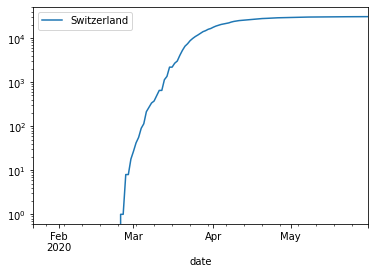

In [22]:
plot_data(swiss, logy=True)

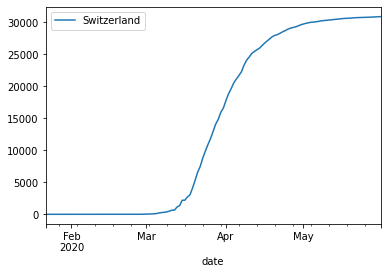

In [23]:
plot_data(swiss)

# Europe

In [24]:
italy = extract_data(df, "Italy")

In [25]:
france = extract_data(df, "France")

In [26]:
uk = extract_data(df, "United Kingdom")

In [27]:
spain = extract_data(df, "Spain")

In [28]:
germany =  extract_data(df, "Germany")

In [29]:
austria =  extract_data(df, "Austria")

In [30]:
europe = pd.concat([swiss, italy, france, germany, austria, spain, uk], axis=1)

In [31]:
# europe.columns = ['Switzerland', 'Italy', 'France', 'Germany', 'Austria', 'Spain', 'UK']

In [32]:
europe

Switzerland   Italy  France  Germany  Austria   Spain  \
date       day_of_year                                                          
2020-01-22 22                     0       0       0        0        0       0   
2020-01-23 23                     0       0       0        0        0       0   
2020-01-24 24                     0       0       2        0        0       0   
2020-01-25 25                     0       0       3        0        0       0   
2020-01-26 26                     0       0       3        0        0       0   
...                             ...     ...     ...      ...      ...     ...   
2020-05-27 148                30776  231139  180044   181524    16591  236259   
2020-05-28 149                30796  231732  183309   182196    16628  237906   
2020-05-29 150                30828  232248  183816   182922    16655  238564   
2020-05-30 151                30845  232664  185616   183189    16685  239228   
2020-05-31 152                30862  232997  185851   183410    16731  239479   

                        United Kingdom  
date       day_of_year                  
2020-01-22 22                        0  
2020-01-23 23                        0  
2020-01-24 24                        0  
2020-01-25 25                        0  
2020-01-26 26                        0  
...                                ...  
2020-05-27 148                  267240  
2020-05-28 149                  269127  
2020-05-29 150                  271222  
2020-05-30 151                  272826  
2020-05-31 152                  274762  

[131 rows x 7 columns]

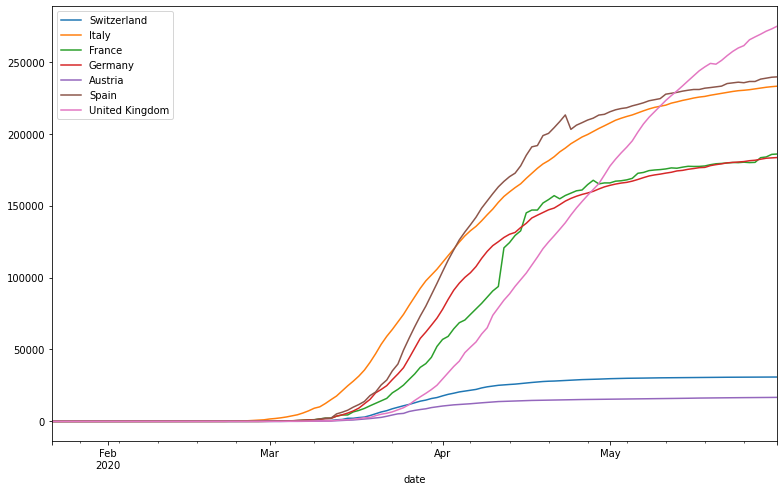

In [33]:
plot_data(europe, figsize=(13, 8))

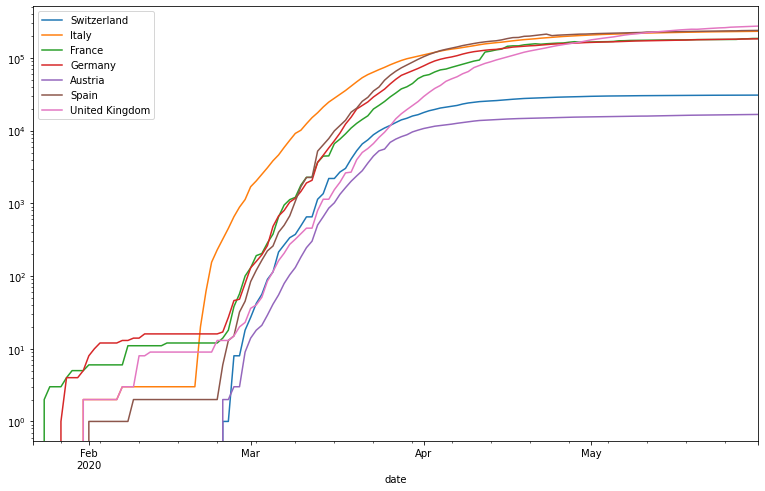

In [34]:
plot_data(europe, logy=True, figsize=(13, 8))

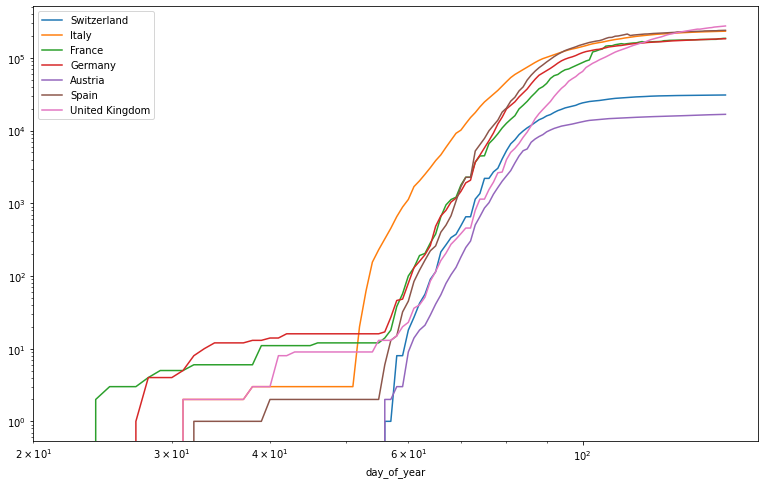

In [35]:
plot_data(europe, logy=True, logx=True, figsize=(13, 8))

# USA

In [36]:
us = extract_data(df, country="US", groupby=True)

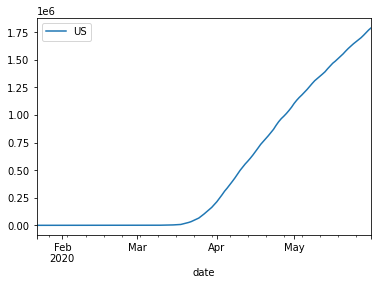

In [37]:
plot_data(us)

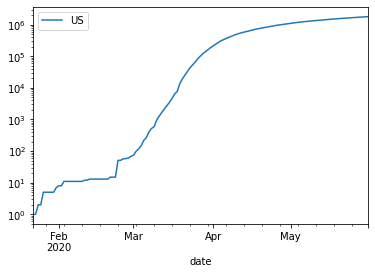

In [38]:
plot_data(us, logy=True)

# Europe + USA

In [39]:
comp_us = pd.concat([europe, us], axis=1)

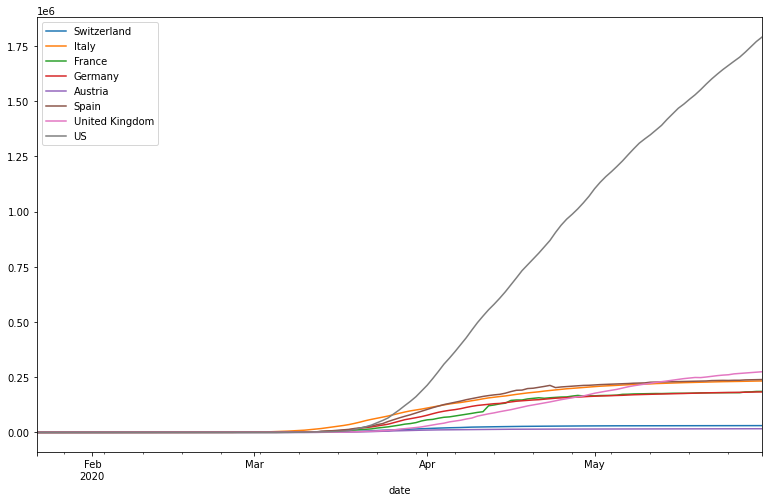

In [40]:
plot_data(comp_us, figsize=(13, 8))

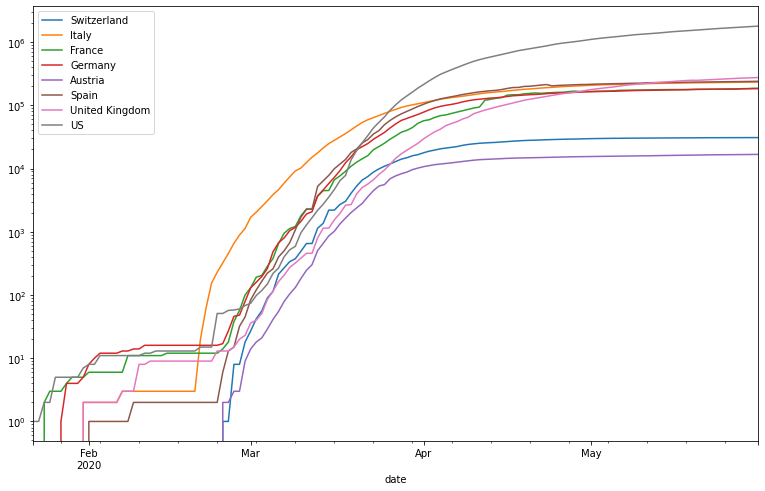

In [41]:
plot_data(comp_us, logy=True, figsize=(13, 8))

# Worldwide

In [42]:
world = df.sum(axis=0).drop(index=['Country/Region']).to_frame()

In [43]:
world.index = pd.to_datetime(world.index)

In [44]:
world["day_of_year"] = world.index.dayofyear

In [45]:
world.reset_index(inplace=True)

In [46]:
world.columns = ["date", "world_cases", "day_of_year"]

In [47]:
world.set_index(["date", "day_of_year"], inplace=True)

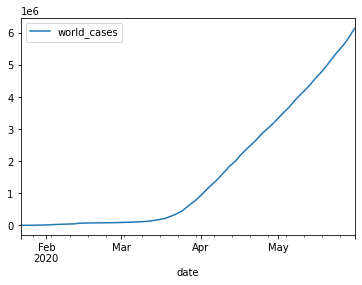

In [48]:
plot_data(world)

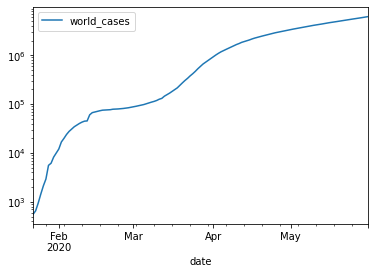

In [49]:
plot_data(world, logy=True)

# Iran

In [50]:
iran = extract_data(df, "Iran")

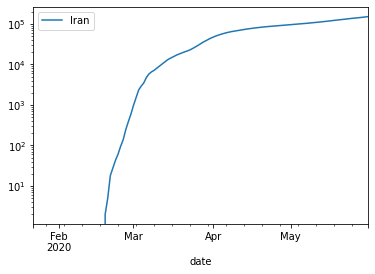

In [51]:
plot_data(iran, logy=True)

In [52]:
comp_iran = pd.concat([comp_us, iran], axis=1)

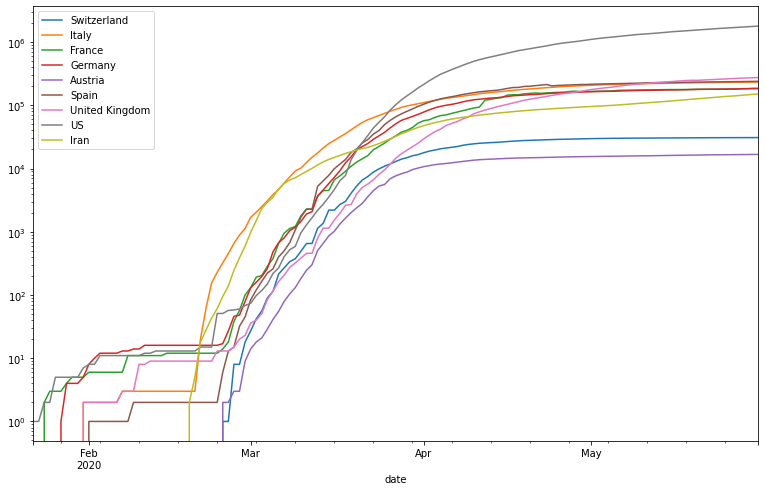

In [53]:
plot_data(comp_iran, logy=True, figsize=(13, 8))

# China

In [54]:
china = extract_data(df, "China", groupby=True)

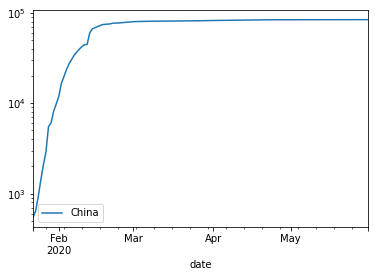

In [55]:
plot_data(china, logy=True)

In [56]:
comp_china = pd.concat([china, comp_us], axis=1)

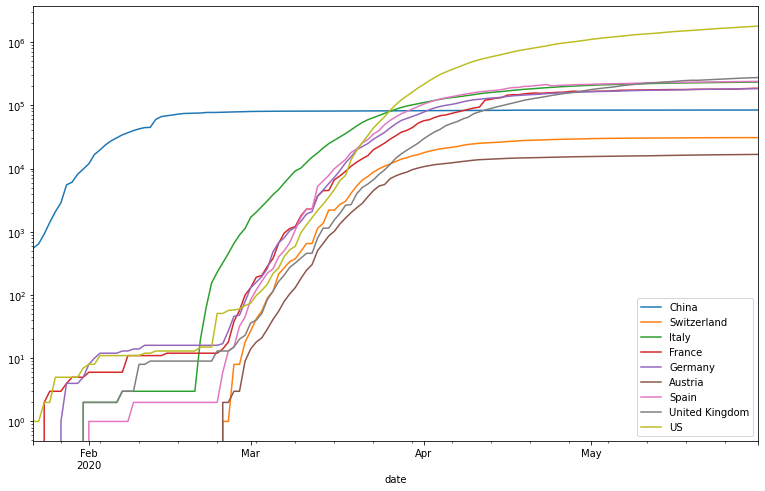

In [57]:
plot_data(comp_china, logy=True, figsize=(13, 8))

# Shanghai

In [58]:
shanghai = extract_data(df, "China", "Shanghai")

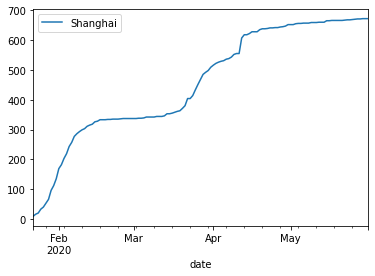

In [59]:
plot_data(shanghai)

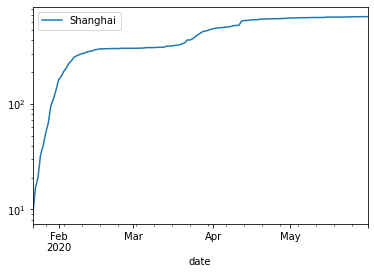

In [60]:
plot_data(shanghai, logy=True)

# Singapore

In [61]:
singapore = extract_data(df, "Singapore")

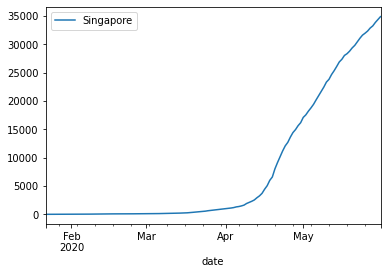

In [62]:
plot_data(singapore)

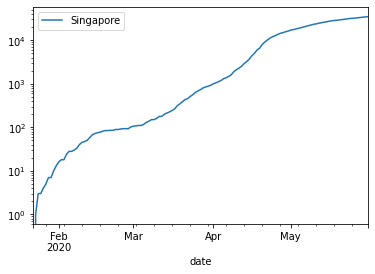

In [63]:
plot_data(singapore, logy=True)

# South Korea

In [64]:
kr = extract_data(df, "Korea, South")

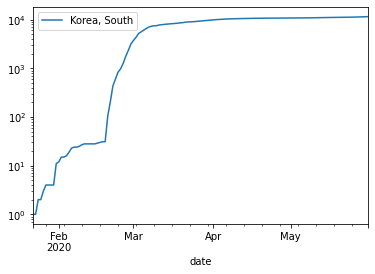

In [65]:
plot_data(kr, logy=True)

# South Central China

## Hong Kong

In [66]:
hong_kong = extract_data(df,"China", "Hong Kong")

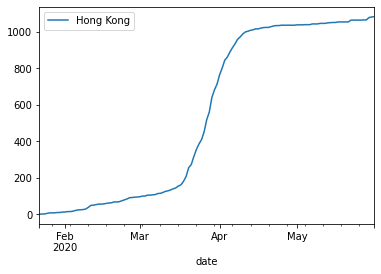

In [67]:
plot_data(hong_kong)

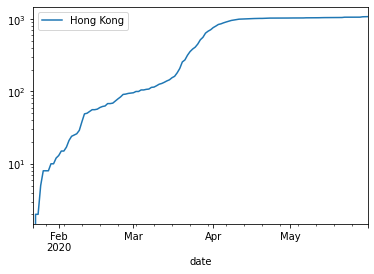

In [68]:
plot_data(hong_kong, logy=True)

## Hubei (Wuhan)

In [69]:
hubei = extract_data(df,"China", "Hubei")

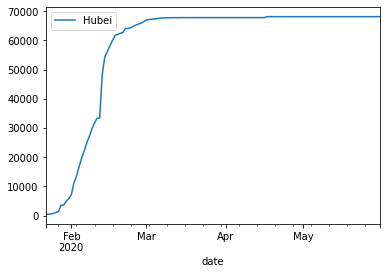

In [70]:
plot_data(hubei)

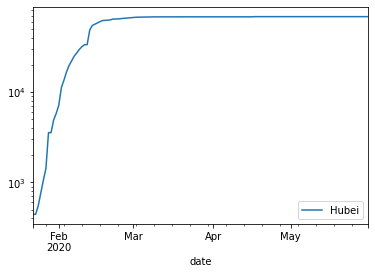

In [71]:
plot_data(hubei, logy=True)

## Henan

In [72]:
henan = extract_data(df, "China", "Henan")

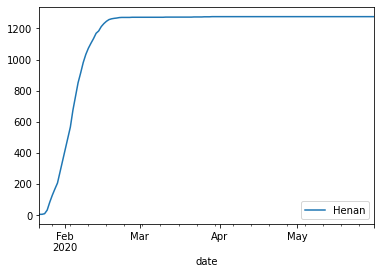

In [73]:
plot_data(henan)

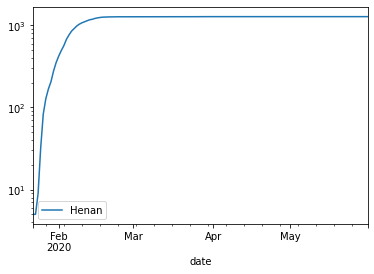

In [74]:
plot_data(henan, logy=True)

## Hunan

In [75]:
hunan = extract_data(df, "China", "Hunan")

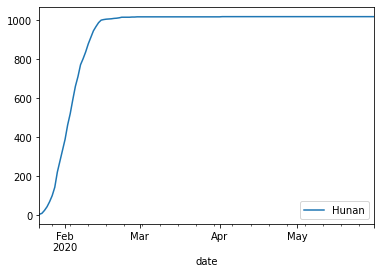

In [76]:
plot_data(hunan)

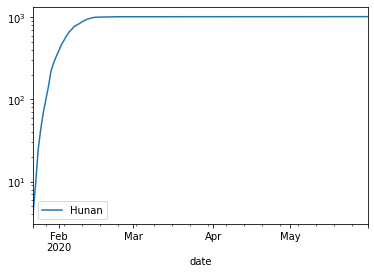

In [77]:
plot_data(hunan, logy=True)

## Guangdong

In [78]:
guangdong = extract_data(df, "China", "Guangdong")

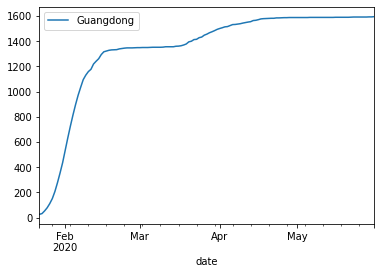

In [79]:
plot_data(guangdong)

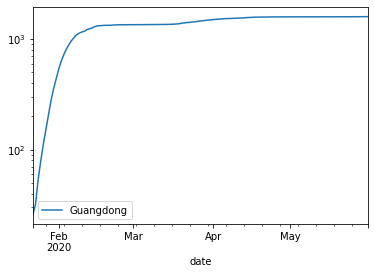

In [80]:
plot_data(guangdong, logy=True)

## Guangxi

In [81]:
guangxi = extract_data(df, "China", "Guangxi")

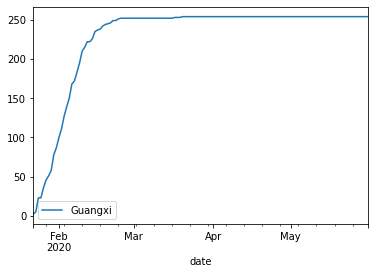

In [82]:
plot_data(guangxi)

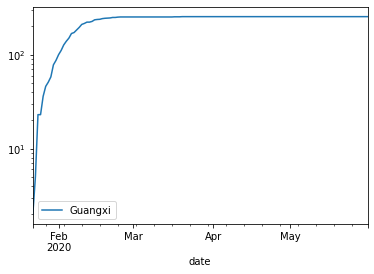

In [83]:
plot_data(guangxi, logy=True)

# South-Asia

In [84]:
south_asia = pd.concat([singapore, hong_kong, shanghai, kr, italy], axis=1)

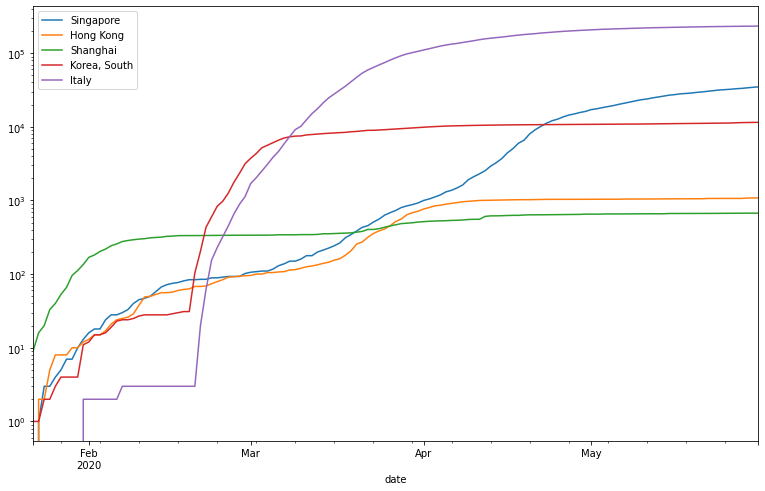

In [85]:
plot_data(south_asia, logy=True, figsize=(13, 8))

# North Europe

In [86]:
sweden = extract_data(df, "Sweden")

In [87]:
norway = extract_data(df, "Norway")

In [88]:
danemark = extract_data(df, 'Danemark')

In [89]:
finland = extract_data(df, 'Finland')

In [90]:
nl = extract_data(df, "Netherlands")

In [91]:
nort_eu = pd.concat([swiss, germany, sweden, norway, danemark, finland, nl], axis=1)

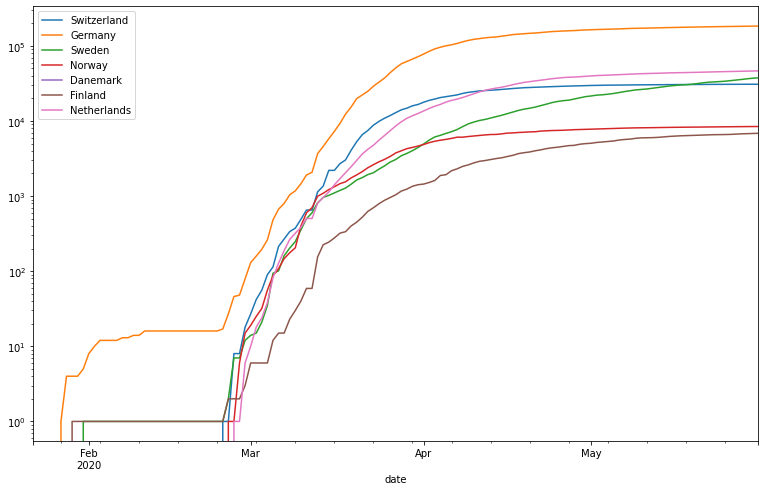

In [92]:
plot_data(nort_eu, logy=True, figsize=(13, 8))

# Death

In [93]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

In [94]:
death = pd.read_csv(url)

In [95]:
death.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  5/22/20  5/23/20  5/24/20  5/25/20  \
0        0        0        0  ...      205      216      218      219   
1        0        0        0  ...       31       31       32       32   
2        0        0        0  ...      582      592      600      609   
3        0        0        0  ...       51       51       51       51   
4        0        0        0  ...        3        4        4        4   

   5/26/20  5/27/20  5/28/20  5/29/20  5/30/20  5/31/20  
0      220      227      235      246      249      257  
1       33       33       33       33       33       33  
2      617      623      630      638      646      653  
3       51       51       51       51       51       51  
4        4        4        4        4        4        4  

[5 rows x 135 columns]

In [96]:
death.drop(columns=['Lat', 'Long'], inplace=True)

In [97]:
uk_death = extract_data(death, "United Kingdom")

In [98]:
us_death = extract_data(death, "US", groupby=True)

In [99]:
it_death = extract_data(death, "Italy")

In [100]:
es_death = extract_data(death, "Spain")

In [101]:
de_death = extract_data(death, "Germany")

In [102]:
cn_death = extract_data(death, "China", groupby=True)

In [103]:
fr_death = extract_data(death, "France")

In [104]:
ch_death = extract_data(death, "Switzerland")

In [105]:
comp_death = pd.concat([it_death, uk_death, us_death, es_death, de_death, cn_death, ch_death, fr_death], axis=1)

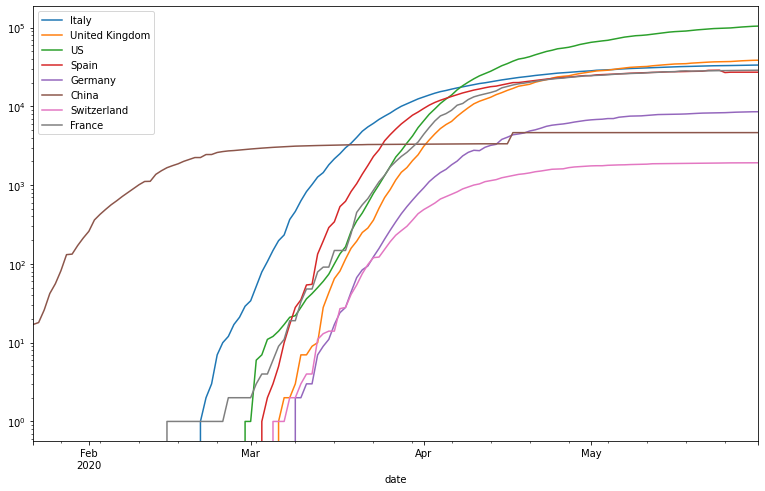

In [106]:
plot_data(comp_death, logy=True, figsize=(13, 8))

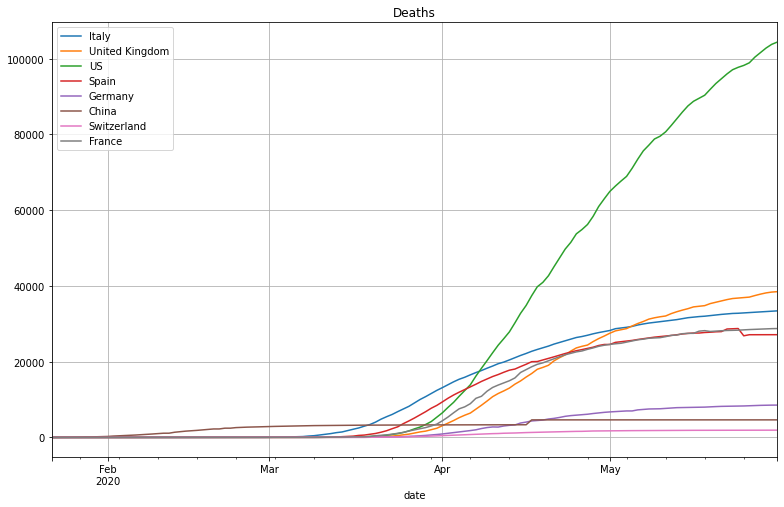

In [107]:
plot_data(comp_death, figsize=(13, 8), title="Deaths", grid=True)

In [108]:
world_death = death.sum(axis=0).drop(index=['Country/Region']).to_frame()

In [109]:
world_death.index = pd.to_datetime(world_death.index)

In [110]:
world_death["day_of_year"] = world_death.index.dayofyear

In [111]:
world_death.reset_index(inplace=True)

In [112]:
world_death.columns = ["date", "world_death", "day_of_year"]

In [113]:
world_death.set_index(["date", "day_of_year"], inplace=True)

In [114]:
comp_world = add(world, world_death, "World")

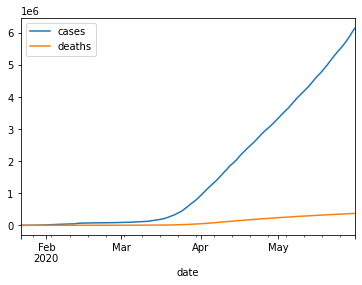

In [115]:
plot_data(comp_world[["cases", "deaths"]])

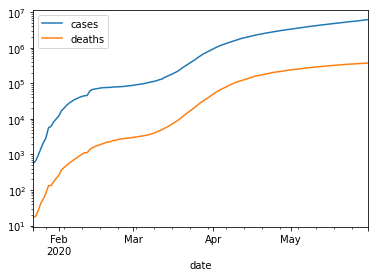

In [116]:
plot_data(comp_world[["cases", "deaths"]], logy=True)

In [117]:
comp_world["death_rate"] = comp_world["deaths"] / comp_world["cases"]

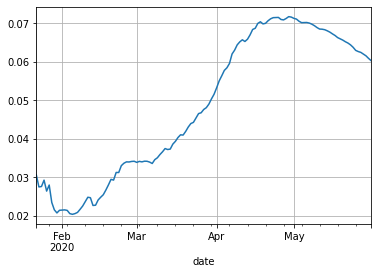

In [118]:
plot_data(comp_world["death_rate"], grid=True)

In [119]:
comp_world.to_excel(xl_writer, "World")

In [120]:
xl_writer.close()

In [121]:
df_summary_cases = pd.DataFrame(df[["Country/Region", df.columns[-1]]].groupby(by="Country/Region").sum().to_records())

In [122]:
df_summary_cases.columns = ["Country", "Cases"]

In [123]:
df_summary_deaths = pd.DataFrame(death[["Country/Region", death.columns[-1]]].groupby(by="Country/Region").sum().to_records())

In [124]:
df_summary_deaths.columns = ["Country", "Deaths"]

In [125]:
df_summary = pd.merge(df_summary_cases, df_summary_deaths, how="outer", on="Country")

In [126]:
iso_code = pd.read_csv("country_name_to_iso_code.csv")
iso_code.loc[iso_code["Country"] == "Namibia", "alpha-2"] = "NA"
iso_code[iso_code["Country"] == "Namibia"]

Unnamed: 0  Country alpha-2
150         152  Namibia      NA

In [127]:
df_summary = pd.merge(df_summary, iso_code, how="outer", on="Country")
df_summary.drop(columns=["Unnamed: 0", ], inplace=True)

In [128]:
df_summary.sort_values(by=["Cases",], ascending=False)

Country      Cases    Deaths alpha-2
174                   US  1790172.0  104381.0      US
23                Brazil   514849.0   29314.0      BR
140               Russia   405843.0    4693.0      RU
178       United Kingdom   276156.0   38571.0      GB
158                Spain   239479.0   27127.0      ES
..                   ...        ...       ...     ...
245               Tuvalu        NaN       NaN      TV
246  U.S. Virgin Islands        NaN       NaN      VI
247        United States        NaN       NaN      US
248              Vanuatu        NaN       NaN      VU
249      Wallis & Futuna        NaN       NaN      WF

[250 rows x 4 columns]

In [129]:
number_of_countries = 15

In [130]:
by_countries = df_summary.copy().drop(columns="alpha-2").set_index("Country")

In [131]:
by_countries.sort_values(by="Cases", ascending=False, inplace=True)

In [132]:
by_countries.head(25)

Cases    Deaths
Country                            
US              1790172.0  104381.0
Brazil           514849.0   29314.0
Russia           405843.0    4693.0
United Kingdom   276156.0   38571.0
Spain            239479.0   27127.0
Italy            232997.0   33415.0
India            190609.0    5408.0
France           189009.0   28805.0
Germany          183410.0    8540.0
Peru             164476.0    4506.0
Turkey           163942.0    4540.0
Iran             151466.0    7797.0
Chile             99688.0    1054.0
Canada            92479.0    7374.0
Mexico            90664.0    9930.0
Saudi Arabia      85261.0     503.0
China             84146.0    4638.0
Pakistan          69496.0    1483.0
Belgium           58381.0    9467.0
Qatar             56910.0      38.0
Bangladesh        47153.0     650.0
Netherlands       46645.0    5975.0
Belarus           42556.0     235.0
Ecuador           39098.0    3358.0
Sweden            37542.0    4395.0

In [133]:
[by_countries.iloc[:number_of_countries].sum(), ]

[Cases     4785239.0
 Deaths     315455.0
 dtype: float64]

In [134]:
by_countries = pd.concat([
    by_countries.iloc[:number_of_countries],
    pd.DataFrame([by_countries.iloc[number_of_countries:].sum(), ])
]
)

In [135]:
by_countries.rename(index={0: 'others'}, inplace=True)

In [136]:
by_countries

Cases    Deaths
US              1790172.0  104381.0
Brazil           514849.0   29314.0
Russia           405843.0    4693.0
United Kingdom   276156.0   38571.0
Spain            239479.0   27127.0
Italy            232997.0   33415.0
India            190609.0    5408.0
France           189009.0   28805.0
Germany          183410.0    8540.0
Peru             164476.0    4506.0
Turkey           163942.0    4540.0
Iran             151466.0    7797.0
Chile             99688.0    1054.0
Canada            92479.0    7374.0
Mexico            90664.0    9930.0
others          1381707.0   56580.0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f047d9a4290>,
      dtype=object)

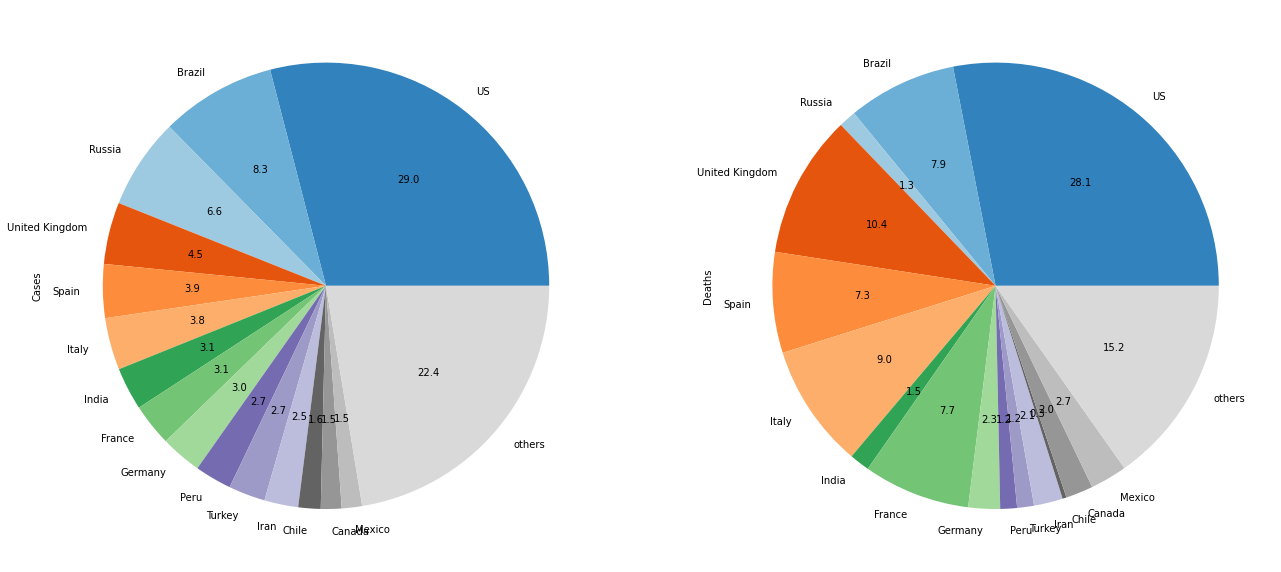

In [137]:
by_countries.plot.pie(subplots=True, figsize=(22, 11), cmap=plt.cm.get_cmap('tab20c'), legend=False, autopct='%.1f')

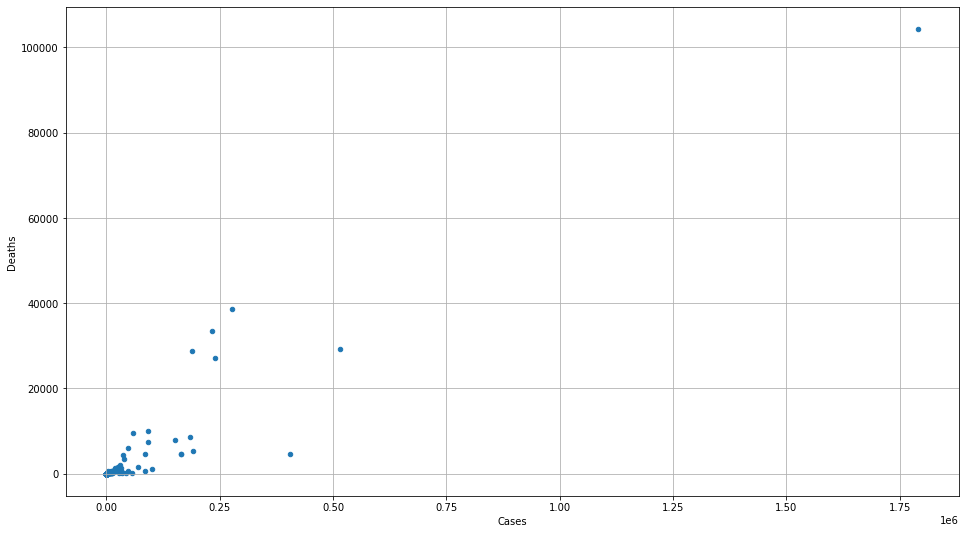

In [138]:
df_summary.plot.scatter(x="Cases", y="Deaths", figsize=(16, 9), grid=True)

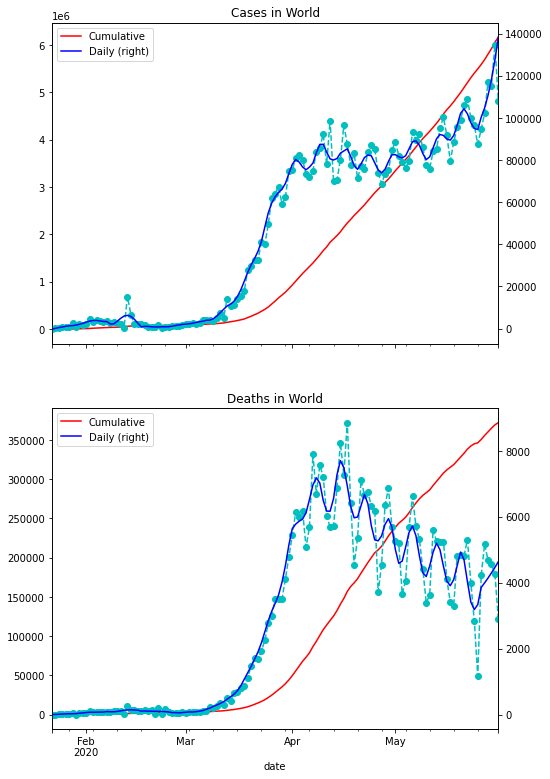

In [139]:
plot_daily(comp_world)

In [140]:
se = add(df, death, "Sweden")

In [141]:
uk = add(df, death, "United Kingdom")

In [142]:
it = add(df, death, "Italy")

In [143]:
sp = add(df, death, "Spain")

In [144]:
fr = add(df, death, "France")

In [145]:
ch = add(df, death, "Switzerland")

In [146]:
be = add(df, death, "Belgium")

In [147]:
de = add(df, death, "Germany")

In [148]:
kr = add(df, death, "Korea, South")

In [149]:
nl = add(df, death, "Netherlands")

In [150]:
us = add(df, death, "US")

In [151]:
sg = add(df, death, "Singapore")

In [152]:
br = add(df, death, "Brazil")

In [153]:
pe = add(df, death, "Peru")

In [154]:
ru = add(df, death, "Russia")

In [155]:
tu = add(df, death, "Turkey")

In [156]:
ir = add(df, death, "Iran")

In [157]:
ar = add(df, death, "Argentina")

In [158]:
mex = add(df, death, "Mexico")

In [159]:
chi = add(df, death, "Chile")

In [160]:
co = add(df, death, "Colombia")

In [161]:
india = add(df, death, "India")

In [162]:
pak = add(df, death, "Pakistan")

In [163]:
ind = add(df, death, "Indonesia")

In [164]:
dz = add(df, death, "Algeria")

In [165]:
mar = add(df, death, "Morocco")

In [167]:
# can = add(df, death, "Canada")

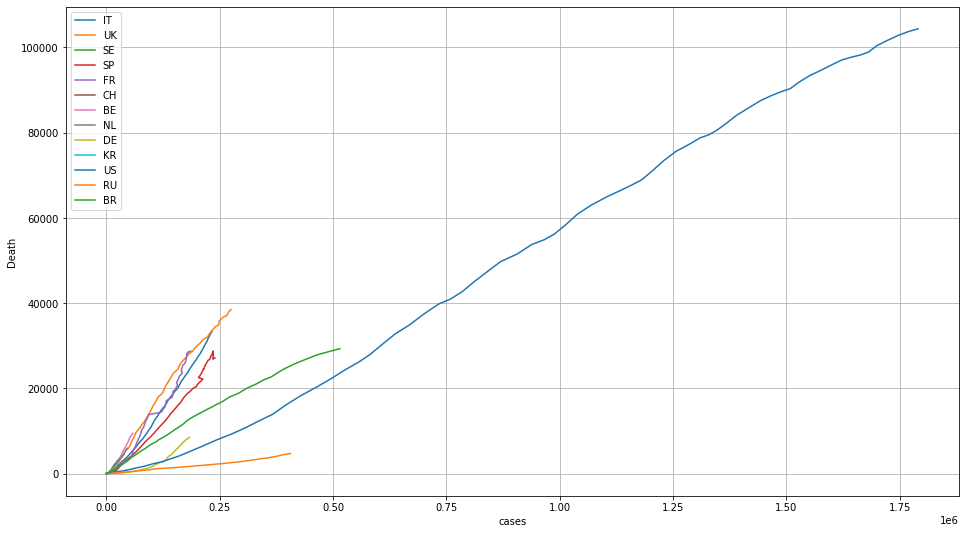

In [168]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_ylabel("Death")
it.plot(x="cases", y="deaths", ax=ax, grid=True, label="IT")
uk.plot(x="cases", y="deaths", ax=ax, grid=True, label="UK")
se.plot(x="cases", y="deaths", ax=ax, grid=True, label="SE")
sp.plot(x="cases", y="deaths", ax=ax, grid=True, label="SP")
fr.plot(x="cases", y="deaths", ax=ax, grid=True, label="FR")
ch.plot(x="cases", y="deaths", ax=ax, grid=True, label="CH")
be.plot(x="cases", y="deaths", ax=ax, grid=True, label="BE")
nl.plot(x="cases", y="deaths", ax=ax, grid=True, label="NL")
de.plot(x="cases", y="deaths", ax=ax, grid=True, label="DE")
kr.plot(x="cases", y="deaths", ax=ax, grid=True, label="KR")
us.plot(x="cases", y="deaths", ax=ax, grid=True, label="US")
ru.plot(x="cases", y="deaths", ax=ax, grid=True, label="RU")
br.plot(x="cases", y="deaths", ax=ax, grid=True, label="BR")

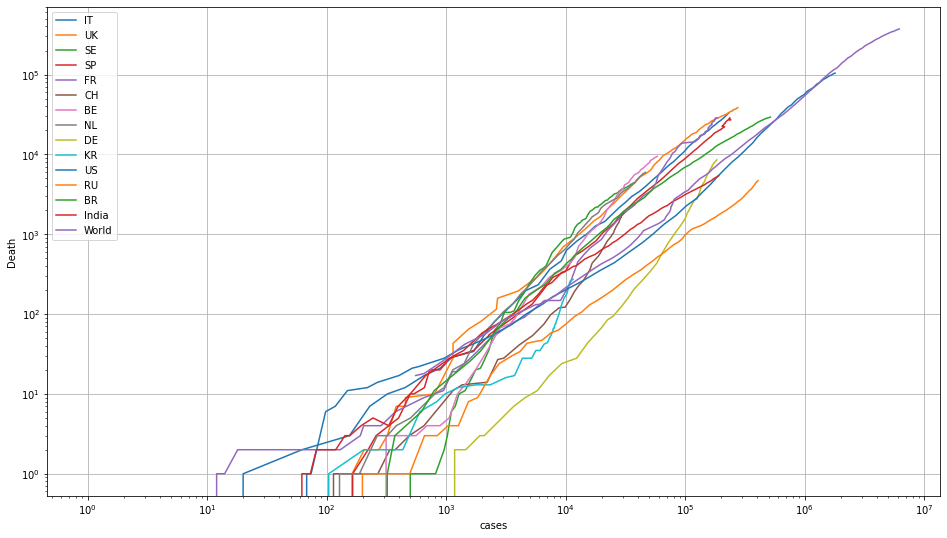

In [169]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_ylabel("Death")
it.plot(x="cases", y="deaths", ax=ax, grid=True, label="IT", loglog=True)
uk.plot(x="cases", y="deaths", ax=ax, grid=True, label="UK")
se.plot(x="cases", y="deaths", ax=ax, grid=True, label="SE")
sp.plot(x="cases", y="deaths", ax=ax, grid=True, label="SP")
fr.plot(x="cases", y="deaths", ax=ax, grid=True, label="FR")
ch.plot(x="cases", y="deaths", ax=ax, grid=True, label="CH")
be.plot(x="cases", y="deaths", ax=ax, grid=True, label="BE")
nl.plot(x="cases", y="deaths", ax=ax, grid=True, label="NL")
de.plot(x="cases", y="deaths", ax=ax, grid=True, label="DE")
kr.plot(x="cases", y="deaths", ax=ax, grid=True, label="KR")
us.plot(x="cases", y="deaths", ax=ax, grid=True, label="US")
ru.plot(x="cases", y="deaths", ax=ax, grid=True, label="RU")
br.plot(x="cases", y="deaths", ax=ax, grid=True, label="BR")
india.plot(x="cases", y="deaths", ax=ax, grid=True, label="India")
comp_world.plot(x="cases", y="deaths", ax=ax, grid=True, label="World")

In [170]:
by_countries.index

Index(['US', 'Brazil', 'Russia', 'United Kingdom', 'Spain', 'Italy', 'India',
       'France', 'Germany', 'Peru', 'Turkey', 'Iran', 'Chile', 'Canada',
       'Mexico', 'others'],
      dtype='object')

In [171]:
def plot_daily(data):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 13))
    dataframe = data.copy()
    dataframe.reset_index("day_of_year", drop=True, inplace=True)
    dataframe["cases"].plot(color="r", 
                            title=f"Cases in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax1)
    ax11 = dataframe["daily_cases"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax1)  
    dataframe["daily_cases_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax1)
    ax1.set_ylabel("Cumulative cases")
    ax11.set_ylabel("Daily Cases")
    #
    dataframe["deaths"].plot(color="r", 
                            title=f"Deaths in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax2)
    ax22 = dataframe["daily_death"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax2)  
    dataframe["daily_death_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax2)
    ax2.set_ylabel("Cumulative cases")
    ax22.set_ylabel("Daily deaths")

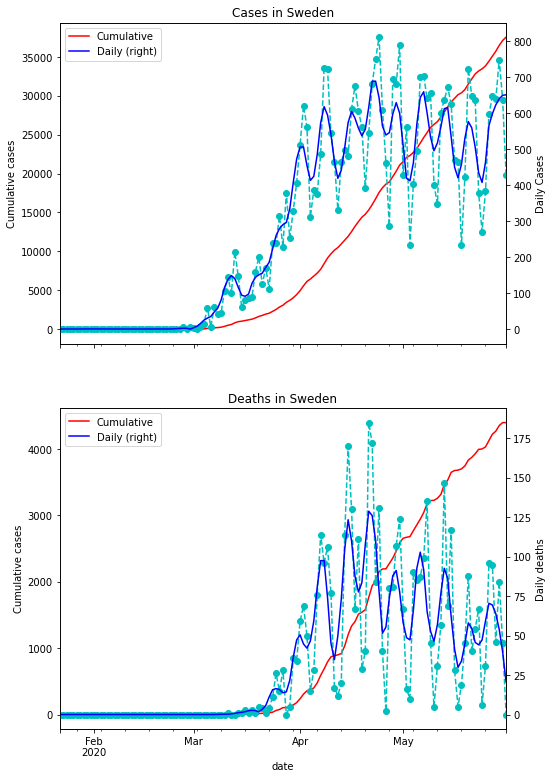

In [172]:
plot_daily(se)

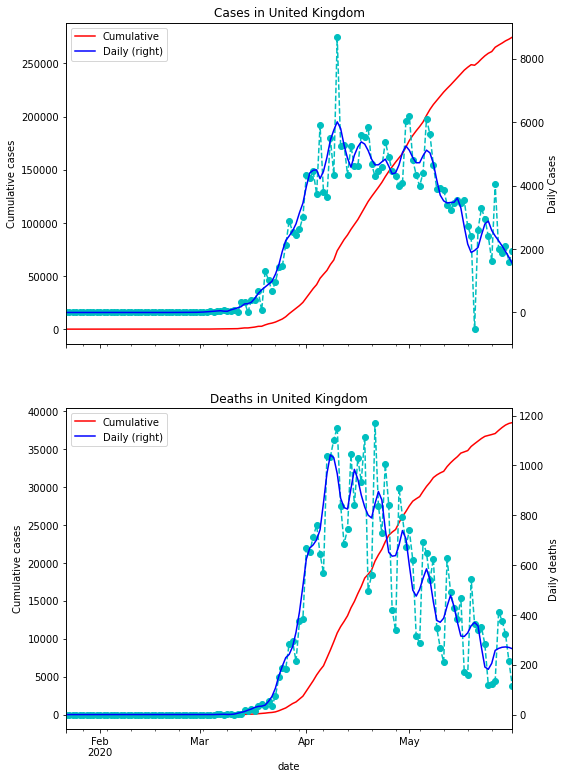

In [173]:
plot_daily(uk)

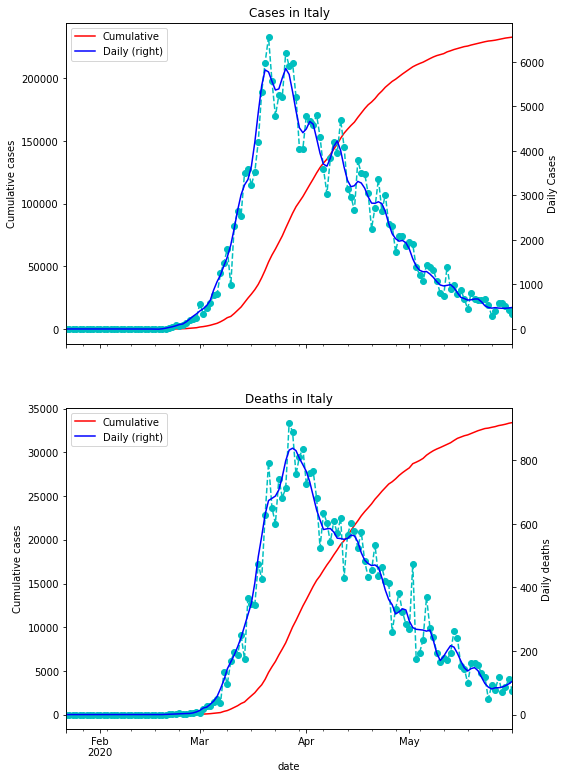

In [174]:
plot_daily(it)

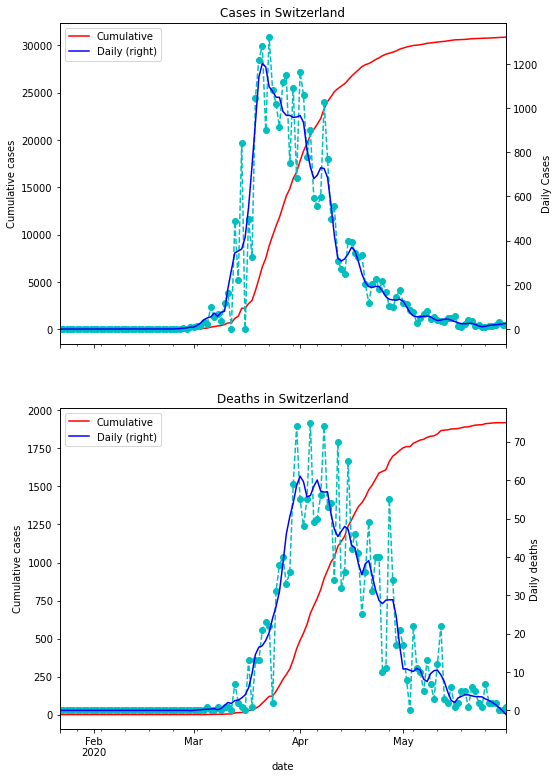

In [175]:
plot_daily(ch)

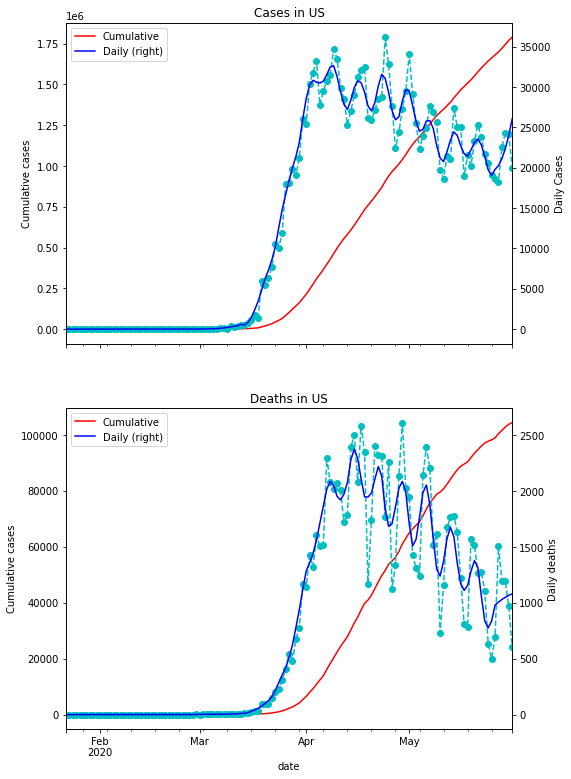

In [176]:
plot_daily(us)

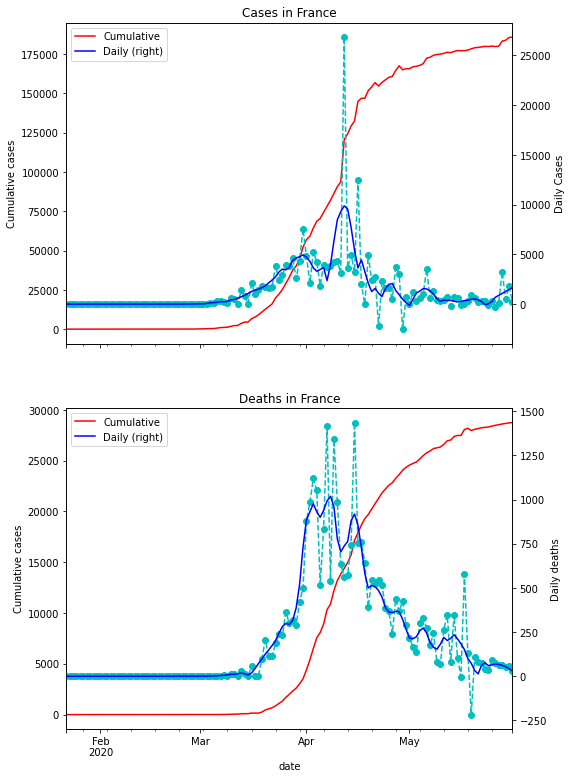

In [177]:
plot_daily(fr)

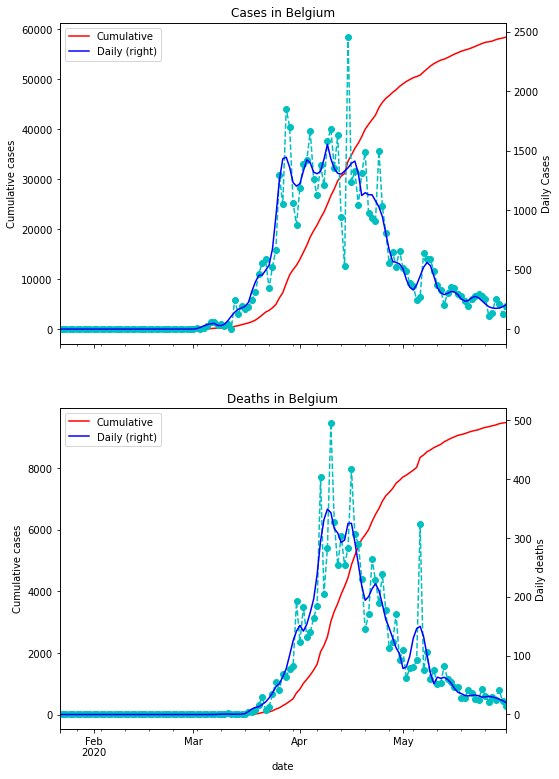

In [178]:
plot_daily(be)

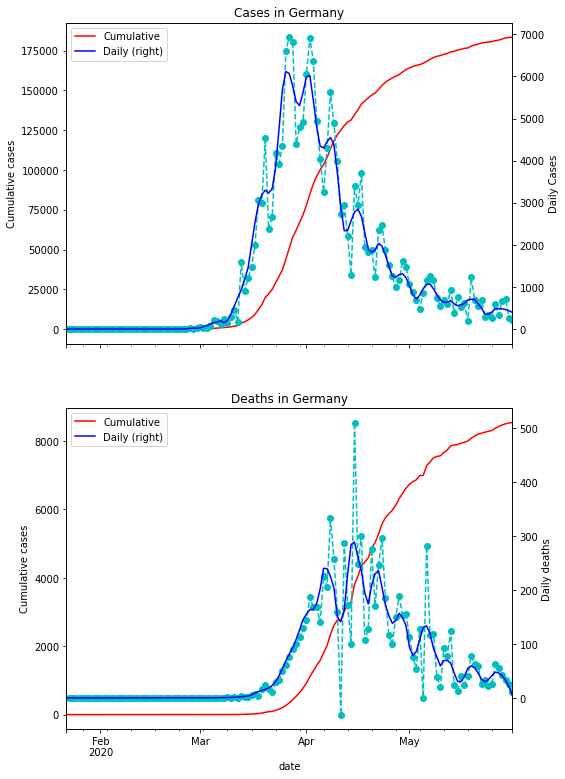

In [179]:
plot_daily(de)

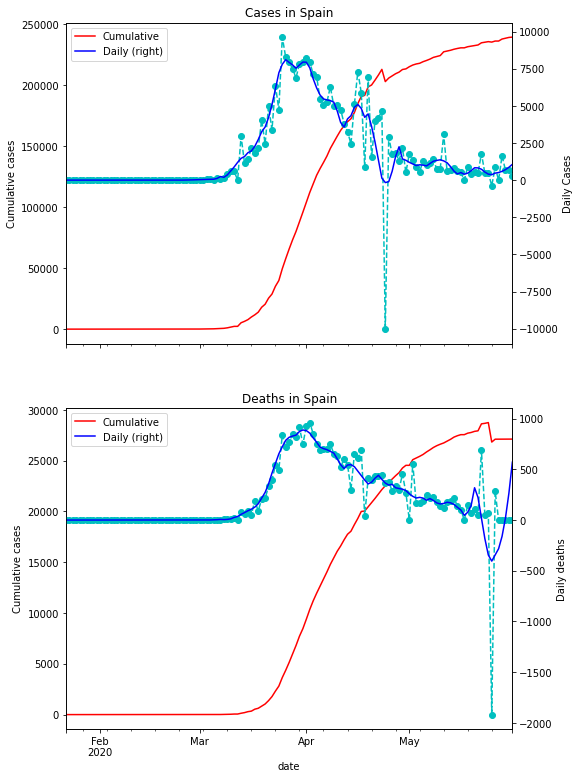

In [180]:
plot_daily(sp)

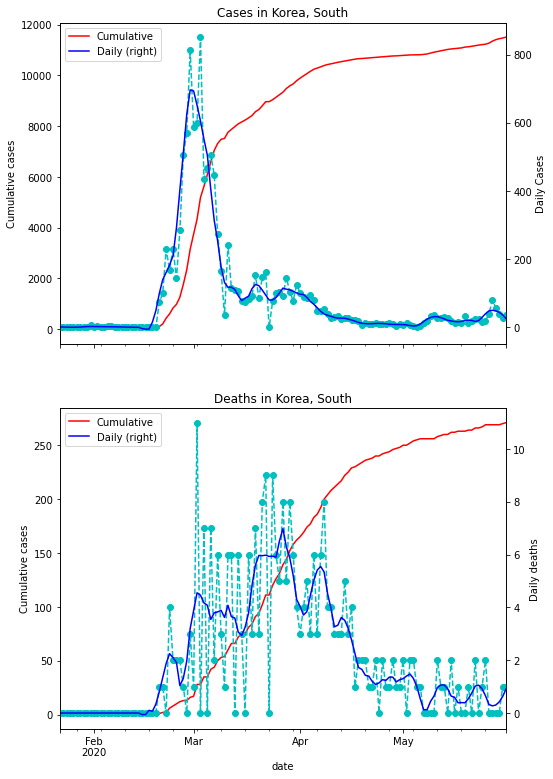

In [181]:
plot_daily(kr)

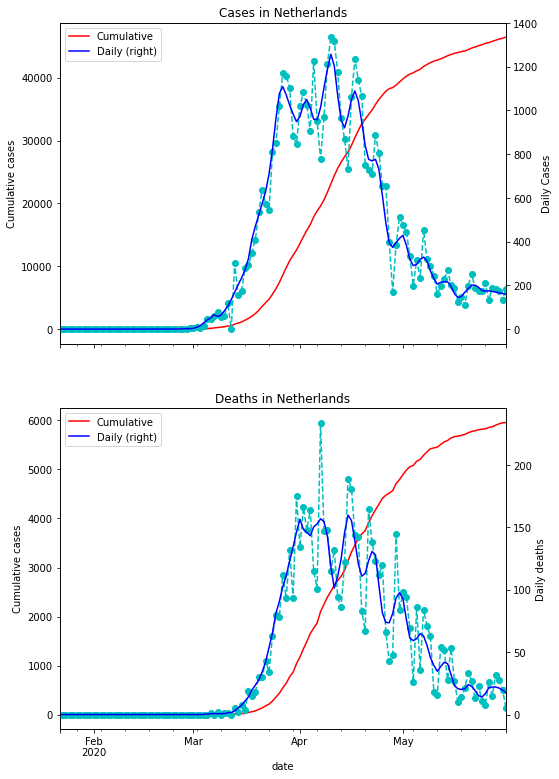

In [182]:
plot_daily(nl)

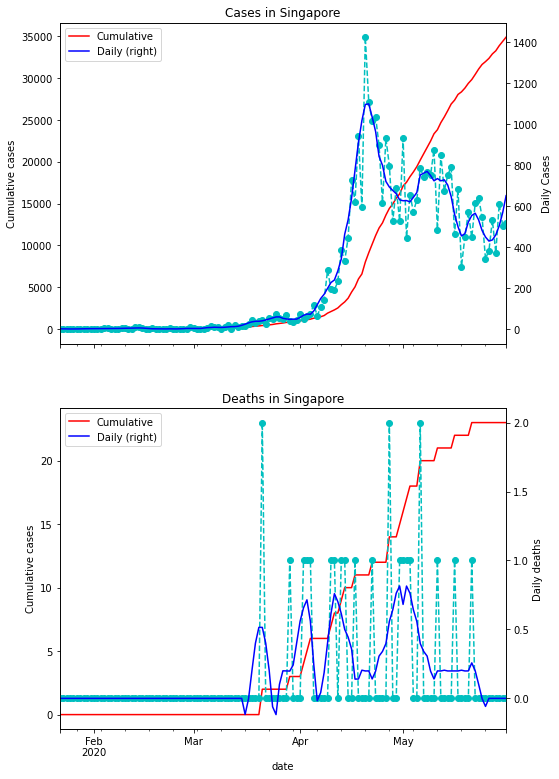

In [183]:
plot_daily(sg)

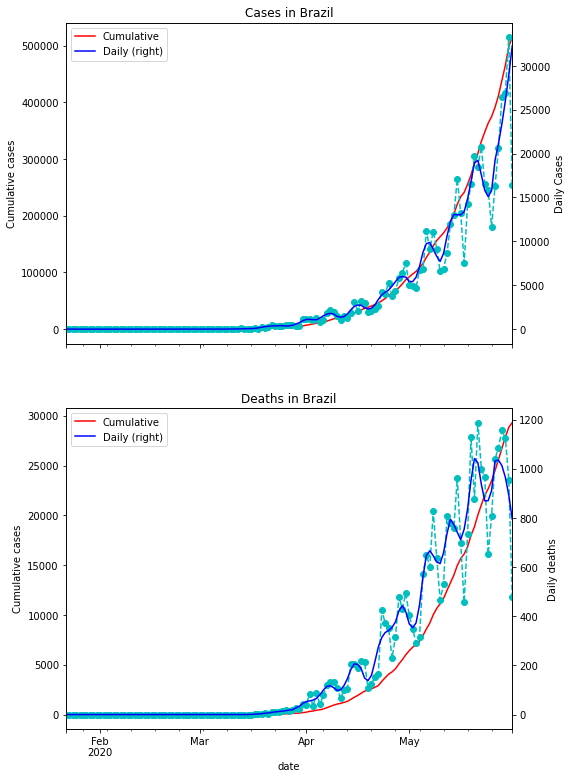

In [184]:
plot_daily(br)

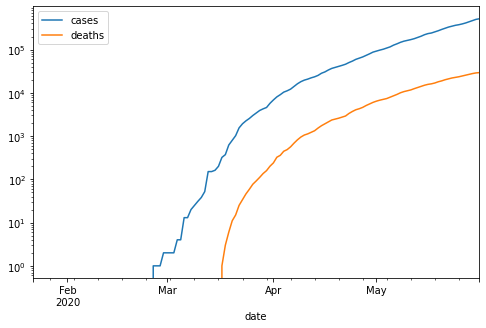

In [185]:
plot_data(br[["cases", "deaths"]], logy=True, figsize=(8, 5))

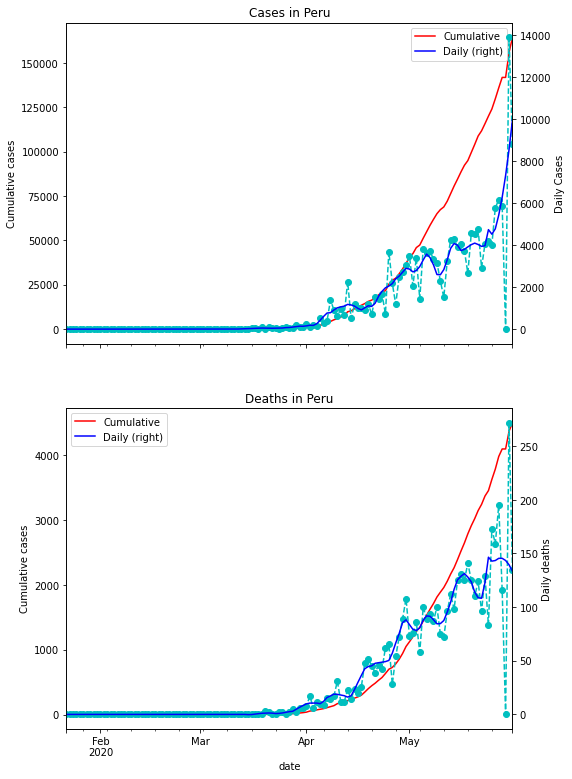

In [186]:
plot_daily(pe)

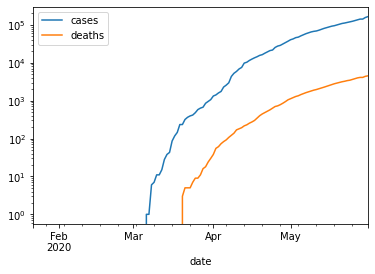

In [187]:
plot_data(pe[["cases", "deaths"]], logy=True)

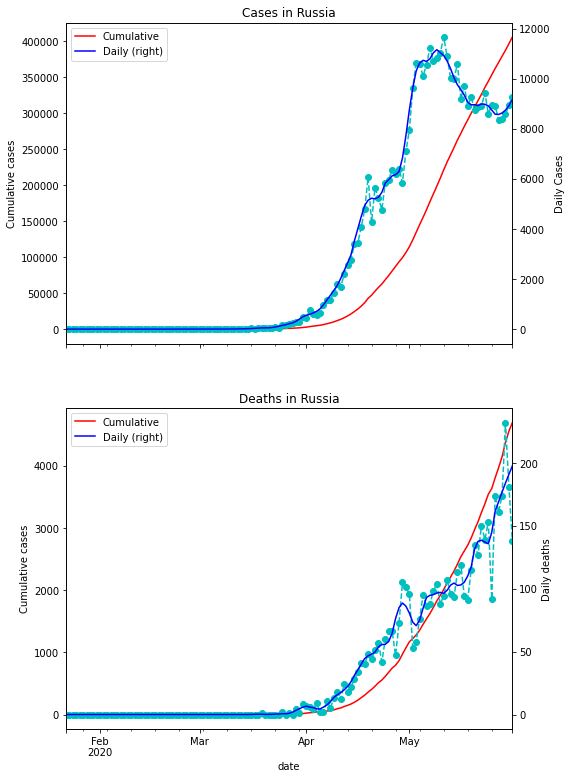

In [188]:
plot_daily(ru)

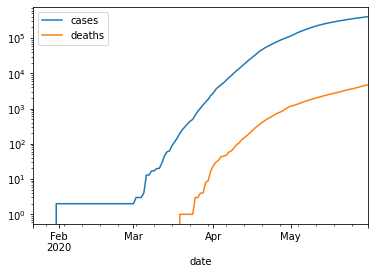

In [189]:
plot_data(ru[["cases", "deaths"]], logy=True)

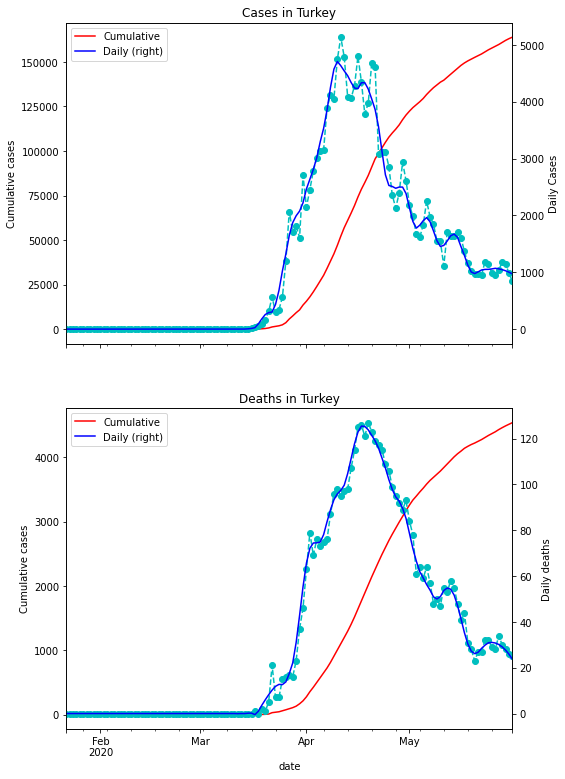

In [190]:
plot_daily(tu)

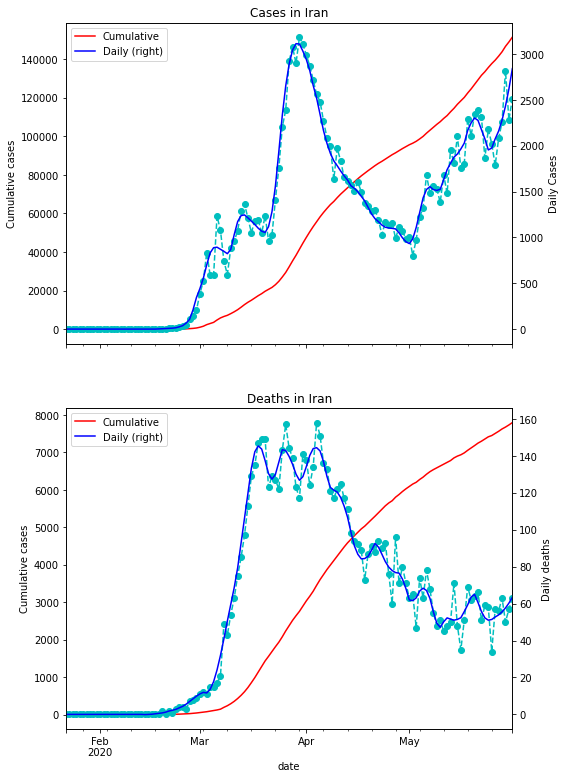

In [191]:
plot_daily(ir)

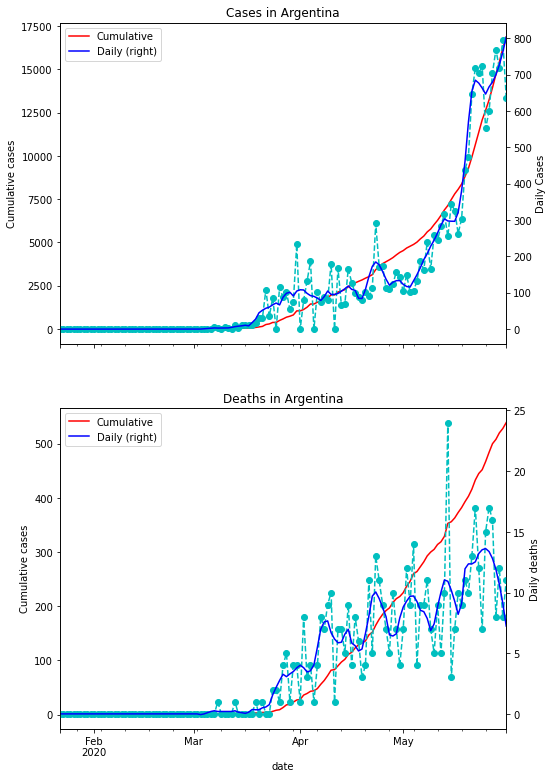

In [192]:
plot_daily(ar)

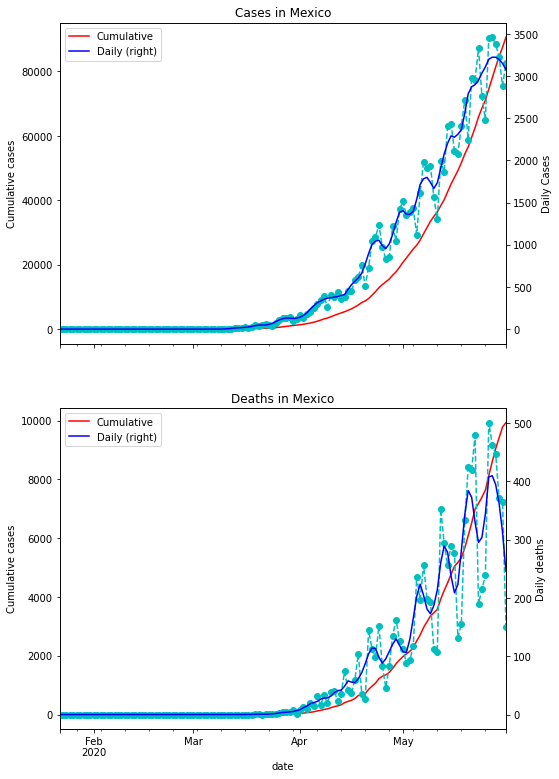

In [193]:
plot_daily(mex)

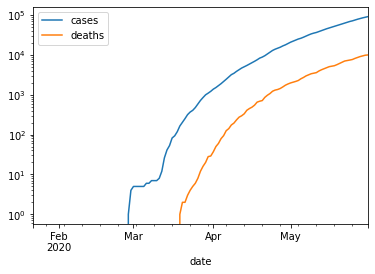

In [194]:
plot_data(mex[["cases", "deaths"]], logy=True)

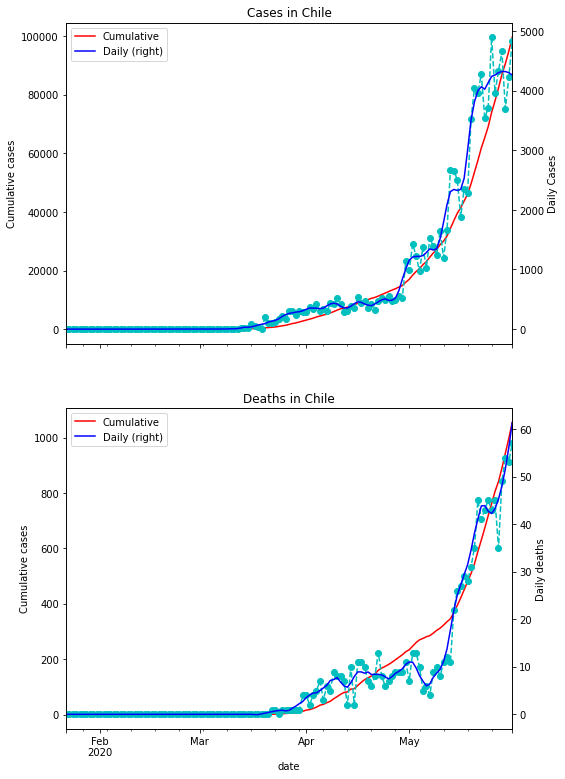

In [195]:
plot_daily(chi)

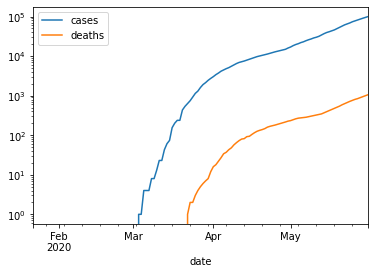

In [196]:
plot_data(chi[["cases", "deaths"]], logy=True)

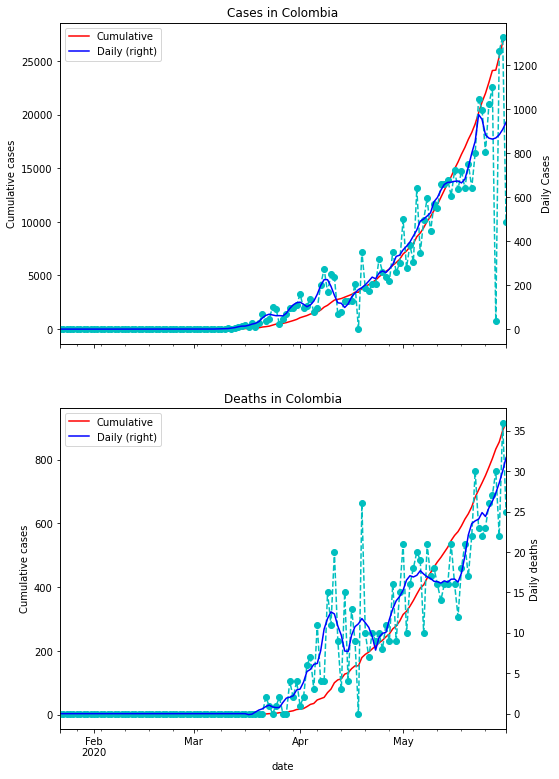

In [197]:
plot_daily(co)

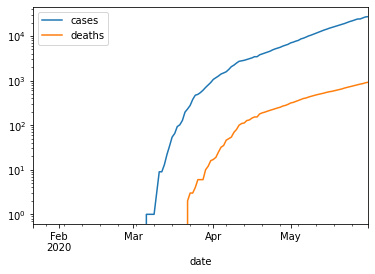

In [198]:
plot_data(co[["cases", "deaths"]], logy=True)

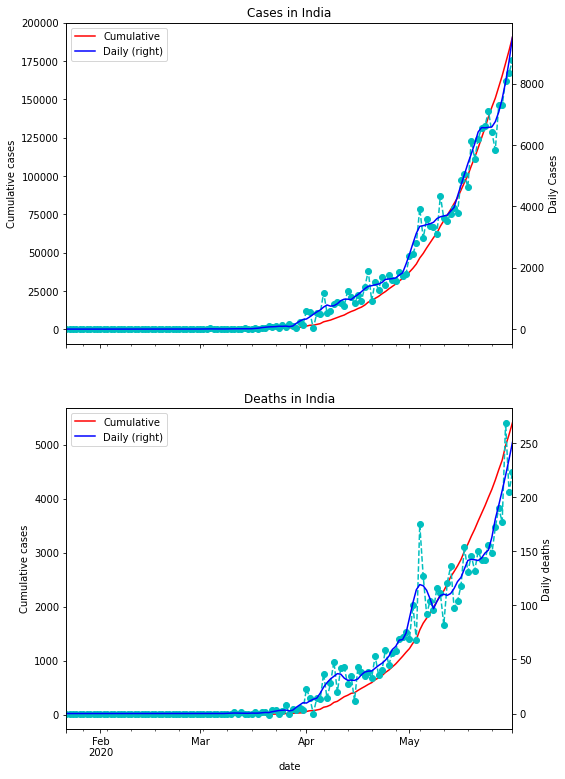

In [199]:
plot_daily(india)

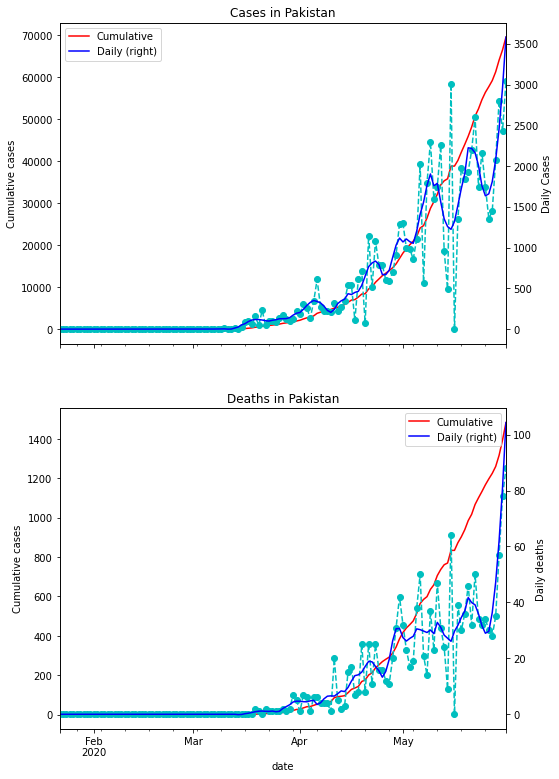

In [200]:
plot_daily(pak)

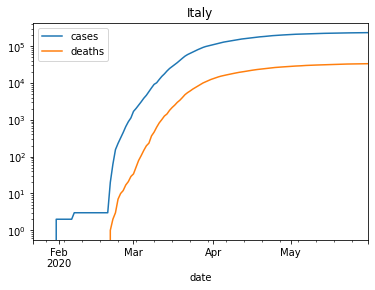

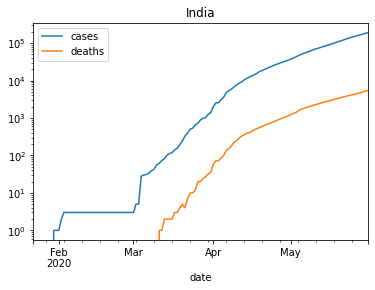

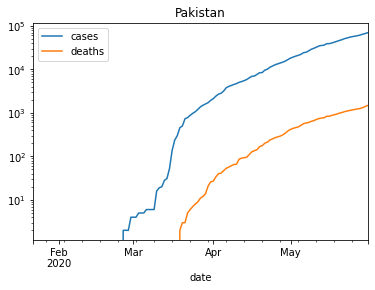

In [201]:
plot_data(it[["cases", "deaths"]], logy=True, title="Italy")
plot_data(india[["cases", "deaths"]], logy=True, title="India")
plot_data(pak[["cases", "deaths"]], logy=True, title="Pakistan")


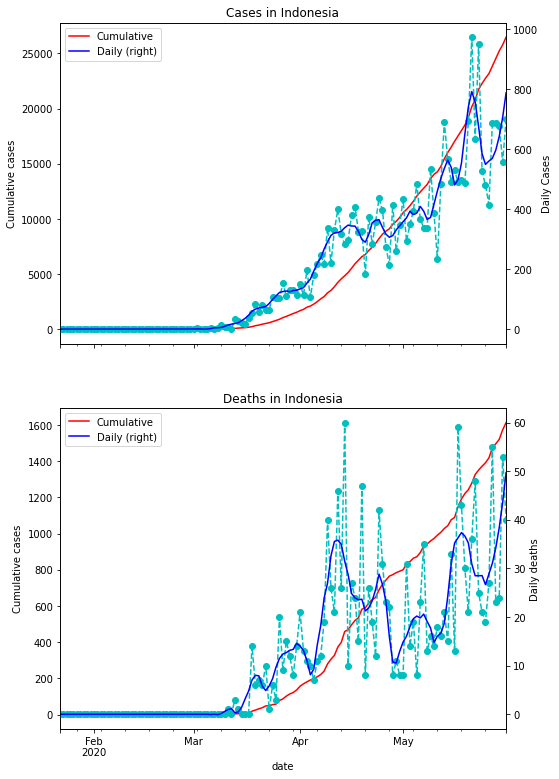

In [202]:
plot_daily(ind)

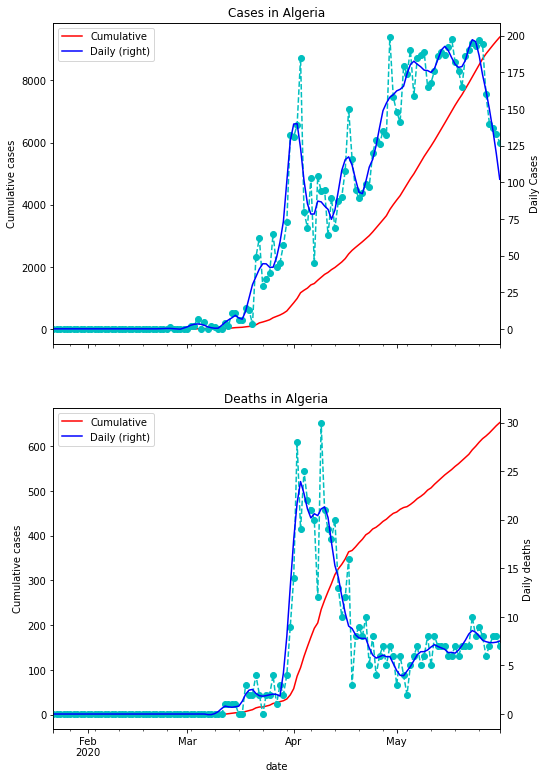

In [203]:
plot_daily(dz)

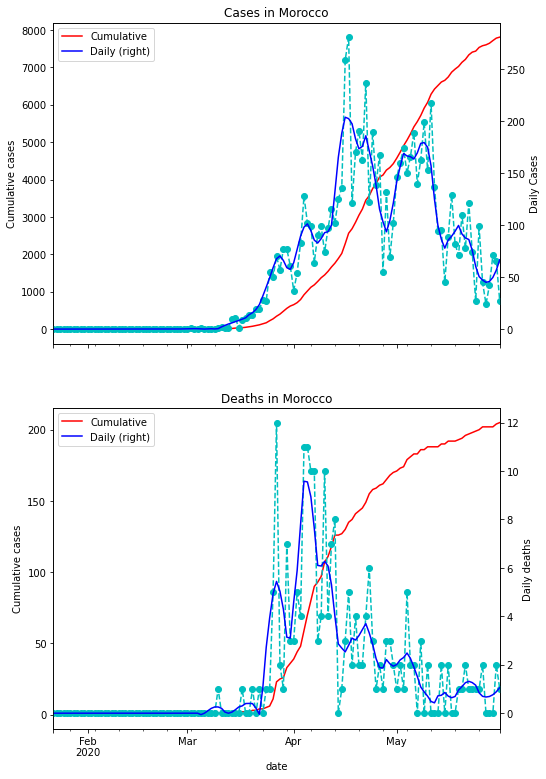

In [204]:
plot_daily(mar)

In [205]:
se.tail(10)

cases  deaths  daily_cases  daily_cases_s  \
date       day_of_year                                              
2020-05-22 143          32809    3925        637.0     506.016706   
2020-05-23 144          33188    3992        379.0     435.260878   
2020-05-24 145          33459    3998        271.0     407.626457   
2020-05-25 146          33843    4029        384.0     463.641803   
2020-05-26 147          34440    4125        597.0     565.834499   
2020-05-27 148          35088    4220        648.0     598.513986   
2020-05-28 149          35727    4266        639.0     623.438228   
2020-05-29 150          36476    4350        749.0     640.607226   
2020-05-30 151          37113    4395        637.0     650.020979   
2020-05-31 152          37542    4395        429.0     651.679487   

                        daily_death  daily_death_s  
date       day_of_year                              
2020-05-22 143                 54.0      45.689005  
2020-05-23 144                 67.0      44.158508  
2020-05-24 145                  6.0      47.204740  
2020-05-25 146                 31.0      59.307304  
2020-05-26 147                 96.0      70.469308  
2020-05-27 148                 95.0      69.395882  
2020-05-28 149                 46.0      63.877234  
2020-05-29 150                 84.0      53.913364  
2020-05-30 151                 45.0      39.504274  
2020-05-31 152                  0.0      20.649961

In [206]:
us.tail(15)

cases  deaths  daily_cases  daily_cases_s  \
date       day_of_year                                                
2020-05-17 138          1486757   89562      18937.0   21732.179876   
2020-05-18 139          1508308   90347      21551.0   21424.361500   
2020-05-19 140          1528568   91921      20260.0   22220.242036   
2020-05-20 141          1551853   93439      23285.0   23111.591880   
2020-05-21 142          1577147   94702      25294.0   23563.003497   
2020-05-22 143          1600937   95978      23790.0   22842.847125   
2020-05-23 144          1622612   97086      21675.0   21395.027389   
2020-05-24 145          1643246   97719      20634.0   19737.936286   
2020-05-25 146          1662302   98219      19056.0   19054.002331   
2020-05-26 147          1680913   98912      18611.0   19794.440754   
2020-05-27 148          1699176  100417      18263.0   20260.577700   
2020-05-28 149          1721753  101616      22577.0   21121.272922   
2020-05-29 150          1746019  102809      24266.0   22376.526418   
2020-05-30 151          1770165  103776      24146.0   24026.338190   
2020-05-31 152          1790172  104381      20007.0   26070.708236   

                        daily_death  daily_death_s  
date       day_of_year                              
2020-05-17 138                808.0    1110.492424  
2020-05-18 139                785.0    1154.573232  
2020-05-19 140               1574.0    1283.407925  
2020-05-20 141               1518.0    1376.718531  
2020-05-21 142               1263.0    1314.918609  
2020-05-22 143               1276.0    1062.674825  
2020-05-23 144               1108.0     837.829643  
2020-05-24 145                633.0     774.900544  
2020-05-25 146                500.0     837.295066  
2020-05-26 147                693.0     979.865385  
2020-05-27 148               1505.0    1006.294872  
2020-05-28 149               1199.0    1029.546037  
2020-05-29 150               1193.0    1049.618881  
2020-05-30 151                967.0    1066.513403  
2020-05-31 152                605.0    1080.229604

In [207]:
it["death_rate"] = it["deaths"] / it["cases"]
ch["death_rate"] = ch["deaths"] / ch["cases"]
se["death_rate"] = se["deaths"] / se["cases"]
uk["death_rate"] = uk["deaths"] / uk["cases"]
be["death_rate"] = be["deaths"] / be["cases"]
sp["death_rate"] = sp["deaths"] / sp["cases"]
de["death_rate"] = de["deaths"] / de["cases"]
us["death_rate"] = us["deaths"] / us["cases"]

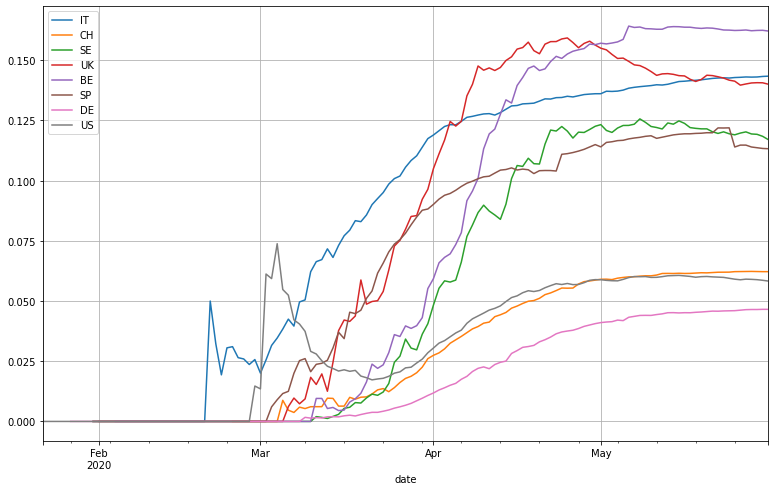

In [235]:
df_rate = pd.concat([it["death_rate"], 
                     ch["death_rate"], 
                     se["death_rate"], 
                     uk["death_rate"],
                     be["death_rate"],
                     sp["death_rate"],
                     de["death_rate"],
                     us["death_rate"],
                    ], axis=1)
df_rate.columns = ["IT", "CH", "SE", "UK", "BE", "SP", "DE", "US"]
df_rate.dropna()
ax =plot_data(df_rate, grid=True, figsize=(13, 8))


In [233]:
df_rate.dropna

Index(['Province/State', 'Country/Region', '1/22/20', '1/23/20', '1/24/20',
       '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       ...
       '5/22/20', '5/23/20', '5/24/20', '5/25/20', '5/26/20', '5/27/20',
       '5/28/20', '5/29/20', '5/30/20', '5/31/20'],
      dtype='object', length=133)